<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day4/detr_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with DETR - a minimal implementation

Based on the [notebooks from Facebook Research](https://github.com/facebookresearch/detr#notebooks)

In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.

We show how to define the model, load pretrained weights and visualize bounding box and class predictions.

Let's start with some common imports.

In [ ]:
import os
import zipfile

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np
from skimage import measure

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
from torchvision.datasets import VOCSegmentation
torch.set_grad_enabled(False);

## DETR
Here is a minimal implementation of DETR:

In [ ]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [ ]:
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU is not available, training will run on the CPU")
    device = torch.device('cpu')

As you can see, DETR architecture is very simple, thanks to the representational power of the Transformer. There are two main components:
* a convolutional backbone - we use ResNet-50 in this demo
* a Transformer - we use the default PyTorch nn.Transformer


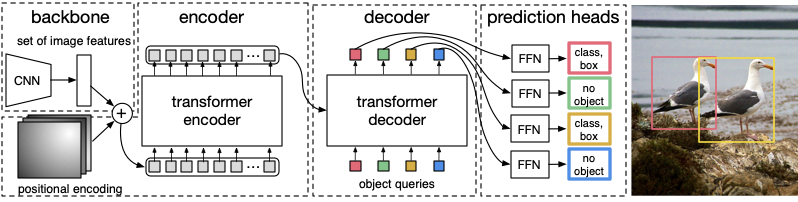

Let's construct the model with 80 COCO output classes + 1 ⦰ "no object" class and load the pretrained weights.
The weights are saved in half precision to save bandwidth without hurting model accuracy.

In [ ]:
detr = DETRdemo(num_classes=91)

state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)

detr.load_state_dict(state_dict)
detr.eval()

detr = detr.to(device)

## Computing predictions with DETR

The pre-trained DETR model that we have just loaded has been trained on the 80 COCO classes, with class indices ranging from 1 to 90 (that's why we considered 91 classes in the model construction).
In the following cells, we define the mapping from class indices to names.

In [ ]:
# COCO classes
COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(500),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    return b

Let's put everything together in a `detect` function:

In [ ]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    img = img.to(device)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

## Loading Pascal VOC 2012 dataset
Before we start let's download the Pascal VOC validation set from the [here](https://oc.embl.de/index.php/s/bkBUhSajTPP0lUP) and save it in your Google Drive. The archive is 2GB in size so it will take a while.

After the ZIP file has been successfully uploaded to your Google Drive, mount your Drive following [the instructions](https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/exercises/mount-gdrive-in-colab.ipynb) and unzip the archive.

In [ ]:
# mount your google drive
# you will need to authorize the access
from google.colab import drive

root = '/content/gdrive/'
drive.mount(root)

# this is the root file for your google drive
gdrive_root = os.path.join(root, 'My Drive')

path_to_zip = os.path.join(gdrive_root, 'PascalVOC2012.zip')

root_dir = os.path.join(gdrive_root, 'PascalVOC2012')
# extract Pascal VOC in your gdrive_root
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    # extract only if not exists
    if not os.path.exists(root_dir):
        print(f'Extracting {path_to_zip}...')
        zip_ref.extractall(gdrive_root)

Let's create the Pascal VOC loader from `torchvision` package and show some images with the ground truth segmentation masks.

In [ ]:
voc_dataset = VOCSegmentation(root_dir, year='2012', image_set='val', download=False)

def show_random_dataset_image(dataset, idx=-1):
    if idx == -1:
        idx = np.random.randint(0, len(dataset))    # take a random sample
    img, mask = dataset[idx]                    # get the image and the nuclei masks
    img, mask = np.array(img), np.array(mask)
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img)                     # show the image
    axarr[1].imshow(mask)                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print(f'Image size: {img.shape}')
    plt.show()

In [ ]:
show_random_dataset_image(voc_dataset)

Before we move on let's define the 20 classes of objects avialable in the Pascal VOC dataset

In [ ]:
# Pascal VOC classes, modifed to match the COCO classes, i.e. the following 4 class names were mapped:
# aeroplane -> airplane
# diningtable -> dining table
# motorbike -> motorcycle
# sofa -> couch
# tvmonitor -> tv

PASCAL_CLASSES = [
    'N/A',
    'airplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorcycle',
    'person',
    'potted plant',
    'sheep',
    'couch',
    'train',
    'tv'
]

For the exercises we will need a helper function which extracts the bounding boxes around the individual instances given the ground truth semantic mask.

In [ ]:
def bbox(img, label):
    """
    Extracts the bounding box of a given label in the image.

    Returns:
        tuple (xmin, ymin, xmax, ymax): coordinated of the top left and bottom right corners of the bounding box
    """
    a = np.where(img == label)
    bbox = np.min(a[1]), np.min(a[0]), np.max(a[1]) , np.max(a[0])
    return bbox

def find_boxes(label_img, min_size=100):
    """
    Given the labeled image 'label_img', finds the bounding boxes around different connected components (instances)
    in the image.
    
    Returns:
        tuple (classes, bounding_boxes): where classes is an array of strings, i.e. name of the class of object int the bounding box,
                                         bounding_boxes is an array of tuples of the form (xmin, ymin, ymax, ymax).
    """
    label_img = np.array(label_img)
    label_copy = label_img.copy()
    # zero-out instances boundaries, which in Pascal VOC are given the value of 255
    label_copy[label_copy == 255] = 0
    # find connected components in the labeled image
    connected_components = measure.label(label_copy,  connectivity=1)
    
    classes = []
    boxes = []
    labels, counts = np.unique(connected_components, return_counts=True)
    # iterate over instances and get the bounding box and the corresponding class
    for label, count in zip(labels, counts):
        # skip 0-label or instances smaller than 'min_size' pixels
        if label == 0 or count < min_size:
            continue
        
        # extract and save the bounding box
        boxes.append(bbox(connected_components, label))
        
        # get the class of the object with a given label
        c, n = np.unique(label_img[connected_components == label], return_counts=True)
        ind = c[n.argmax()]
        classes.append(PASCAL_CLASSES[ind])
    
    return classes, boxes

Visualize the bounding boxes on a given image from the Pascal VOC dataset

In [ ]:
def plot_boxes(pil_img, classes, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for cl, (xmin, ymin, xmax, ymax), c in zip(classes, boxes, COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        
        ax.text(xmin, ymin, cl, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.axis('off')
    plt.show()

In [ ]:
img, label_img = voc_dataset[2]

classes, boxes = find_boxes(label_img)

plot_boxes(img, classes, boxes)

## Using DETR
To try DETRdemo model on some image from the Pascal VOC 2012 dataset.

In [ ]:
# take the same image from the loader
im, _ = voc_dataset[2]

# run the prediction
scores, boxes = detect(im, detr, transform)

Let's now visualize the model predictions

In [ ]:
def prob_to_classes(prob):
    return [COCO_CLASSES[p.argmax()] for p in prob]
    
def plot_results(pil_img, prob, boxes):
    classes = prob_to_classes(prob)
    plot_boxes(pil_img, classes, boxes)
    
plot_results(im, scores, boxes)

##### Excercises

1. Use the pre-trained DETR model to detect objects in 20 images randomly sampled from the Pascal VOC dataset. Show predicted bounding boxes together with the ground truth bouding boxes (see `find_boxes` function) side by side. Quantitatively how does the model perform? Do you see any irregularities between the predicted bounding boxes and the ground truth masks?


2. Quantify the object detection performance on the Pascal VOC 2012 dataset using the Mean Average Precision metric. Given a function which returns the ground truth bounding boxes together with their corresponding classes (see `find_boxes`) and bounding box predictions given by the DETR model, compute the `mAP` score at different IoU thresholds (e.g. 0.4, 0.5, 0.75) on the **entire** Pascal VOC 2012 dataset. Details of how to implement `mAP` for object detection ca be found e.g. [here](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173).
You can use the pseudo code below as a starting point

**Hint**
bear in mind that COCO dataset contains 81 classes, whereas Pascal VOC contains 20 classes. For images where DETR model returns one of the 61 classes not present in the Pascal VOC, simply ignore the predicted bounding box instead of counting it as a False Positive.

In [ ]:
def average_precision(gt_classes, gt_boxes, predicted_classes, predicted_boxes, iou_threshold):
    #TODO: implement
    return 0.


# pick an Intersection over Union threshold
iou_threshold = 0.5

average_precision = []

# iterate directly over the Dataset
for img, label in voc_dataset:
    # extact ground truth classes and ground truth boxes from the labeled image
    gt_classes, gt_boxes = find_boxes(label)
    # run the prediction with DETR
    prob, boxes = detect(img, detr, transform)
    
    classes = prob_to_classes(prob)
    
    ap = average_precision(gt_classes, gt_boxes, classes, boxes)
    
    average_precision.append(ap)
    
print(f'mAP@{iou_threshold}:', np.mean(average_precision))